# Variable stars use case notebook

ALeRCE starter notebook for variable star science.

You will need to install psycopg2 and astroquery.

In this notebook you will connect to the ALeRCE database, download some objects with probability greater than 0.7 of being Eclipsing variable, RR Lyrae, or some other class, get selected light curves and plot including doing period folding, as well as querying GAIA for crossmatches

### Load libraries

*External dependencies*:

psycopg2: pip install psycopg2-binary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import astropy.units as u
from astropy import coordinates
import P4J # pip install P4J
import GPy

In [2]:
import ipyaladin as ipyal # see installation instructions here: https://github.com/cds-astro/ipyaladin

### Get credentials (not in github repository)

In [3]:
import json
credentials_file = "../alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

### Connect to DB

In [4]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
cur = conn.cursor()

### Show all the available tables

In [5]:
query = "select tablename from pg_tables where schemaname='public';"

cur.execute(query)
tables = cur.fetchall()

print(tables)

[('class',), ('asassn',), ('crtsnorth',), ('crtssouth',), ('detections',), ('objects',), ('probabilities',), ('xmatch',), ('features',), ('linear',), ('tns',), ('magref',), ('non_detections',), ('tmp',)]


### For each table, show column names and column types

In [6]:
dftab = pd.DataFrame()
for tab in tables:
    cols = pd.DataFrame()
    query = "select column_name from information_schema.columns where table_name = '%s';" % tab
    cur.execute(query)
    results = cur.fetchall()
    if len(results) > 0:
        cols["table"] = [tab[0] for i in results]
        cols["name"] = [res[0] for res in results]
        query = "select data_type from information_schema.columns where table_name = '%s';" % tab
        cur.execute(query)
        cols["dtype"] = [dt[0] for dt in cur.fetchall()]
        dftab = pd.concat([dftab, cols])
pd.options.display.max_rows = 999
display(dftab)
pd.options.display.max_rows = 101

,table,name,dtype
0,class,id,integer
1,class,name,character varying
0,asassn,ASAS-SN Name,text
1,asassn,Other Names,text
2,asassn,LCID,integer
3,asassn,ra,double precision
4,asassn,dec,double precision
5,asassn,Mean VMag,double precision
6,asassn,Amplitude,double precision
7,asassn,Period,double precision


### Classes and their numerical values

In [7]:
classmapper = {"Other": 0, "Ceph": 1, "DSCT": 2, "EB": 3, "LPV": 4, "RRL": 5, "SNe": 6}

# if class_str in ['TDE', 'AGN', 'Pulsating-Other', 'CV', 'Novae', 'Periodic-Other']:
#     numeric_label = 0  #Other
# elif class_str == 'Ceph':
#     numeric_label = 1
# elif class_str == 'DSCT':
#     numeric_label = 2	
# elif class_str in ['EBSD/D', 'EBC']:
#     numeric_label = 3
# elif class_str =='LPV':
#     numeric_label = 4
# elif class_str == 'RRL':
#     numeric_label = 5
# elif class_str in ['SNeIIb', 'SNeIa', 'SNeIIn', 'SNeIb/c', 'SNeII', 'SNeIa-sub']:
#     numeric_label = 6

### Function to query data more easily

In [8]:
def sql_query(query):
    cur.execute(query)
    result = cur.fetchall()
    
    # Extract the column names
    col_names = []
    for elt in cur.description:
        col_names.append(elt[0])

    #Convert to dataframe
    df = pd.DataFrame(np.array(result), columns = col_names)
    return(df)

### Query SN data

In [9]:
query='''
select probabilities.oid, probabilities.other_prob, objects.meanra, 
objects.meandec, objects.nobs, objects.mean_magpsf_g, objects.mean_magpsf_r,
objects.min_magpsf_g, objects.min_magpsf_r, objects.sigma_magpsf_g, objects.sigma_magpsf_r, 
objects.classxmatch, objects.period

from probabilities 

inner join objects
on probabilities.oid=objects.oid

where probabilities.rrl_prob>0.5 and objects.classxmatch=%s
''' % classmapper["RRL"]

RRL = sql_query(query)

RRL.head()

# use oid as the pandas index
RRL.set_index('oid', inplace=True)

### Convert columns to numeric values

In [10]:
for col in list(RRL):
    if col != 'oid':
        print(col)
        RRL[col] = pd.to_numeric(RRL[col], errors = 'ignore')

other_prob
meanra
meandec
nobs
mean_magpsf_g
mean_magpsf_r
min_magpsf_g
min_magpsf_r
sigma_magpsf_g
sigma_magpsf_r
classxmatch
period


### Function to get period

In [11]:
# for the moment use the g band
def doperiod(LCdet):

    objperiod = {}
    freq = {}
    per = {}
    for fid in [1, 2]:
        
        maskdet = LCdet.fid == fid
        
        my_per = P4J.periodogram(method='QMIEU')
        my_per.set_data(np.array(LCdet[maskdet].mjd), np.array(LCdet[maskdet].magpsf_corr),
                        np.array(LCdet[maskdet].sigmapsf_corr))
        my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)
        my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=1)#10)              
        freq[fid], per[fid] = my_per.get_periodogram()
        fbest, pbest = my_per.get_best_frequencies()
        objperiod[fid] = 1. / fbest
        print(fid, objperiod[fid])

    period = objperiod[1]
    
    return period, freq, per

### Function to plot

In [12]:
def plotLC(oid, LCdet, LCnondet, dofold, period=None, freq=None, per=None):

    fig, ax = plt.subplots(figsize = (12, 6))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for idx, fid in enumerate([1, 2]):
        maskdet = LCdet.fid == fid
        masknondet = (LCnondet.fid == fid) & (LCnondet.diffmaglim > -900)
        
        if dofold:
            phase = np.mod(LCdet[maskdet].mjd, period) / period
            ax.errorbar(phase, LCdet[maskdet].magpsf_corr, 
                    yerr = LCdet[maskdet].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid], lw = 0)
        else:
            ax.errorbar(LCdet[maskdet].mjd, LCdet[maskdet].magpsf_corr, 
                    yerr = LCdet[maskdet].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
            ax.scatter(LCnondet[masknondet].mjd, LCnondet[masknondet].diffmaglim, c = colors[fid], alpha = 0.5,
                    marker = 'v', label = "lim.mag. %s" % labels[fid])
    if dofold:
        ax.set_title("%s (period: %.3f days" % (oid, period))
        ax.set_xlabel("phase")
    else:
        ax.set_title(oid)
        ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    if dofold:
        fig, ax = plt.subplots(ncols = 2, figsize = (12, 4))
        for idx, fid in enumerate([1, 2]):
            ax[idx].plot(freq[fid], per[fid])
            ax[idx].set_title("Periodogram %s" % labels[fid])
            ax[idx].set_xlabel("frequency [1/days]")

### Function to get data, fold and plot SN light curve

In [13]:
def getLCdata(oid, doplot=False, dofold=False):

    # query detections
    query = "select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    LCdet = sql_query(query)
    # to numeric
    for col in list(LCdet):
        if col != 'oid':
            LCdet[col] = pd.to_numeric(LCdet[col], errors = 'ignore')
    # sort by jd
    LCdet.sort_values(by=["mjd"], inplace=True)
        
    # query non detections
    query = "select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    LCnondet = sql_query(query)
    # to numeric
    for col in list(LCnondet):
        if col != 'oid':
            LCnondet[col] = pd.to_numeric(LCnondet[col], errors = 'ignore')
    # sort by jd
    LCnondet.sort_values(by=["mjd"], inplace=True)

    if dofold:
        # get period
        period, freq, per = doperiod(LCdet)
    else:
        period = None; freq = None; per = None  
    
    if doplot:
        plotLC(oid, LCdet, LCnondet, dofold, period=period, freq=freq, per=per)
        
    # return data
    return LCdet, LCnondet

### Get the brightest RRL and plot folded light curve

ZTF18aagrhuq
1 [0.6303024]
2 [0.6304137]


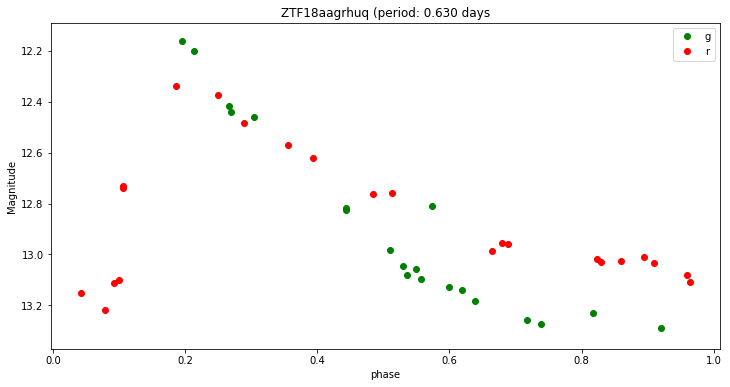

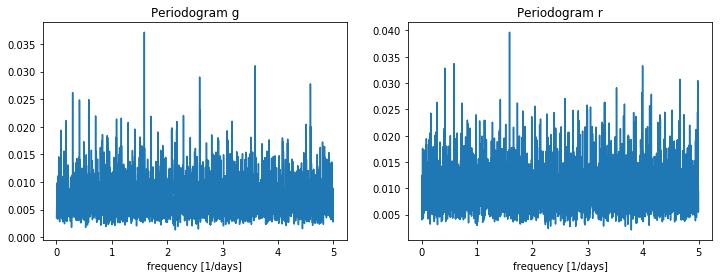

In [14]:
seloid = RRL.min_magpsf_g.idxmin()
print(seloid)
getLCdata(seloid, doplot = True, dofold = True);

### Select a random light curve with period and reference location

1 [7.227]
2 [0.5362649]


Aladin(fov=0.04, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

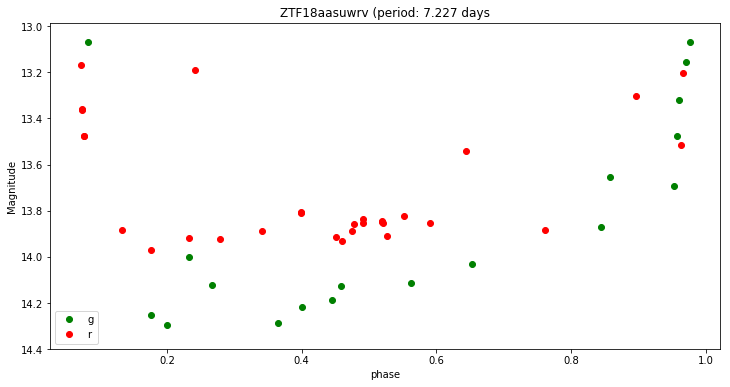

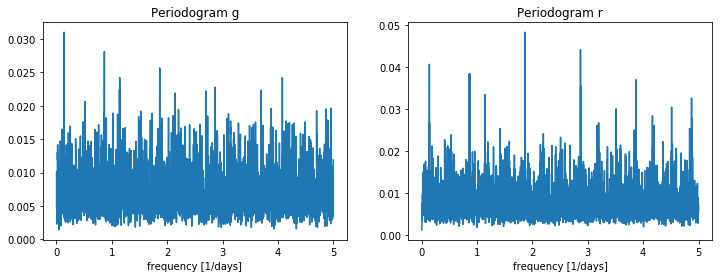

In [15]:
seloid = np.random.choice(RRL.index)
getLCdata(seloid, doplot = True, dofold = True);
aladin= ipyal.Aladin(target='%s %s' % (RRL.meanra[seloid], RRL.meandec[seloid]), fov=0.04, survey='P/SDSS9/color')
aladin